## DeepONet for 1D-Burgers Equation

### 1D Burgers Equation
The 1D Burgers equation is a fundamental nonlinear PDE whose general form can be written as:
\begin{equation}
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}
with initial condition $u(x,0) = u_0(x)$, and boundary conditions that can be periodic, Dirichlet, or Neumann. Where:
* $u(x,t)$ is the velocity field (the conserved quantity),
* $x$ and $t$ are the spatial and temporal coordinates respectively,
* $\nu$ is a viscosity diffusion coefficient.

In the inviscid form($\nu = 0$), it models the  propagation of a wave, where the velocity $u(x,t)$ is both the amplitude (height) of the wave and the speed at which that part of the wave travels, such that each "piece" of the wave travels at a speed equal to its own height. Over time, the wave steepens, developing shocks or sharp discontinuities.

In [1]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.io import loadmat
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
NVIDIA RTX A6000


### The DeepONet

 The DeepONet is a neural network architecture designed to learn nonlinear operators, which are mappings between function spaces. This is particularly useful for solving partial differential equations (PDEs) and other problems where the input and output are entire functions. A DeepONet approximates operators of the form:
 $$\mathcal{G} : u(x) \to \mathcal{G}(u)(y)$$

 Where, $u(x)$ is a function (e.g., an initial condition), and $\mathcal{G}(u)(y)$ is another function (e.g., the solution of a PDE at later time or different location). So, instead of mapping numbers to numbers, DeepONet maps functions to functions.

 *The DeepONet Architecture consists of two subnetworks:*
 
 * **Branch Net**: This is a neural network (can be anytype, CNN, UNet e.t.c.) whose inputs are discrete samples of the input function (initial conditions or function parameters) $u(x)$, usually at fixed sensor locations $x_i$. The branch net encodes the input function into a finite-dimensional feature vector which is a latent vector $b \in \mathbb{R}^p $.
 * **Trunk Net**: This in general is a Feed-forward Neural Network whose inputs are the evaluation location $y$ (the location where you want the output function value, the spatio-temporal coordinates). Similarly to the branch net, it outputs a latent vector $t \in \mathbb{R}$ that encodes these evaluation points.

Finally, the output of the DeepONet is the dot product between the branch and trunk outputs, and approximates the value of the operator $\mathcal{G}$ at point $y$. Thus we have that:
$$\mathcal{G}(u)(y) \approx \sum_{k = 1}^p b_k t_k$$

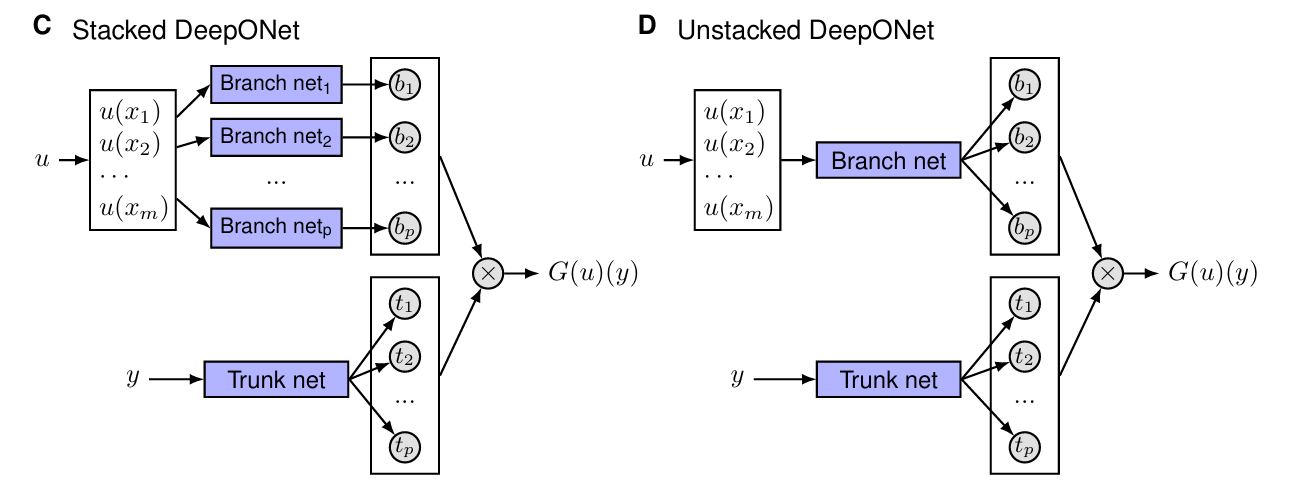

*image from the DeepONet paper by Lu Lu et. al.*

### Dataset

In this Notebook, we will be solving the 1D Burgers equation using DeepONet. We will be using the same 1d Burgers equation dataset as in the 1D FNO tutorial. As a brief recap of the dataset, it contains the $2048$ different samples of the initial velocities $u_0(x)$ and the realizations at time $t=1$ i.e $u_1(x)$.

To learn the operator $\mathcal{G}$ that maps every $u_0(x)$ to $u_1(x)$, we build a DeepONet whose branch inputs each initial condition $u_0$ representing one function realization. The trunk takes the spatial coordinates (positions or spatial grid points) as inputs. Typically, we feed the trunk network all positions repeatedly for each $u_0$ inputted into the trunk net.

### Configurations and data preparation

In [2]:
class config:
  def __init__(self):
    #The training parameters
    self.num_epoch = 300
    self.batch_size = 50

    #Optimizer
    self.lr = 0.001
    self.weight_decay = 1e-3  #Regularization weight

    #The learning rate scheduler
    self.step_size = 75  #To decay after every, say 100 epochs
    self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

    ##Model hyperparameters
    self.tb_dim = 20 #Trunk and branch output dimension
    self.hidden_layers = 125 #Hidden layers for trunk and branch

    #Parameters for the dataset
    self.resolution_original = 8192 #Original spatial resolution
    self.sub_sample = 8    #Reduce the original resolution by a factor of 8, for faster training
    self.total_batches = 2048 #Total number of realizations

    self.dataset_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/burgers_data_R10.mat'
    self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/deeponet_burgers_model.pt'
    self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers_deeponet'


cfg = config()

In [3]:
print(cfg.dataset_path)
print(cfg.model_path)
print(cfg.checkpoint_dir)

C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/burgers_data_R10.mat
C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/deeponet_burgers_model.pt
C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers_deeponet


##### Visualizing the data

In [4]:
burgers_data = loadmat(cfg.dataset_path)

In [5]:
keys_list = [key for key in burgers_data]
print(f"There are {len(keys_list[3:])} keys in the dataset")  #Remove metadata
for i, key_list in enumerate(keys_list[3:]):
    print(f"No. {i+1}: key {key_list} is of type {type(burgers_data[key_list])} and of shape {burgers_data[key_list].shape}")

There are 5 keys in the dataset
No. 1: key a is of type <class 'numpy.ndarray'> and of shape (2048, 8192)
No. 2: key a_smooth is of type <class 'numpy.ndarray'> and of shape (2048, 8192)
No. 3: key a_smooth_x is of type <class 'numpy.ndarray'> and of shape (2048, 8191)
No. 4: key a_x is of type <class 'numpy.ndarray'> and of shape (2048, 8191)
No. 5: key u is of type <class 'numpy.ndarray'> and of shape (2048, 8192)


From the above, key "a" contains the initials conditions (input) $u_0 = u(x,0)$. While key "u" contains the final velocities at time t = 1.  

It can be seen data there are $2048$ samples, and the spatial resolution is $8192$. We are going to subsample to $1024$ point.

But first, we will  visualize some of the initial and final velocities in the data.

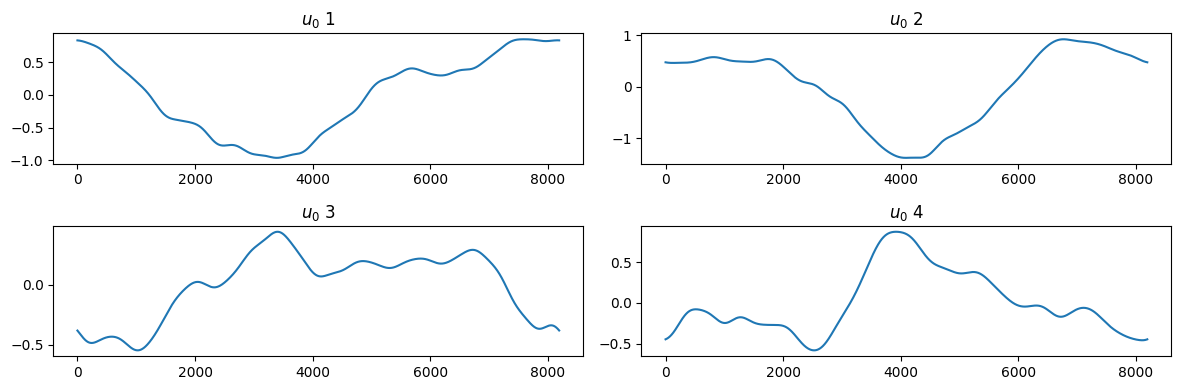

In [6]:
#Initial conditions
u0 = burgers_data[keys_list[3]]
plt.figure(figsize = (12,4))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(u0[i], label = f"Initial condition {i}")
    plt.title(f"$u_0$ {i+1}")
plt.tight_layout()
plt.show()

In [7]:
#Each u0 contains different boundary conditions
for i in range(5):
    p = u0[i]
    print(f"For i = {i}, the bounds are ({p[0]}, {p[-1]})")

For i = 0, the bounds are (0.8354110393896517, 0.8354778757699199)
For i = 1, the bounds are (0.47407752994591507, 0.47431059240719836)
For i = 2, the bounds are (-0.38015727607108896, -0.37957441999625674)
For i = 3, the bounds are (-0.4465217629280464, -0.44681886677830435)
For i = 4, the bounds are (0.004025255017620043, 0.0036375770377164727)


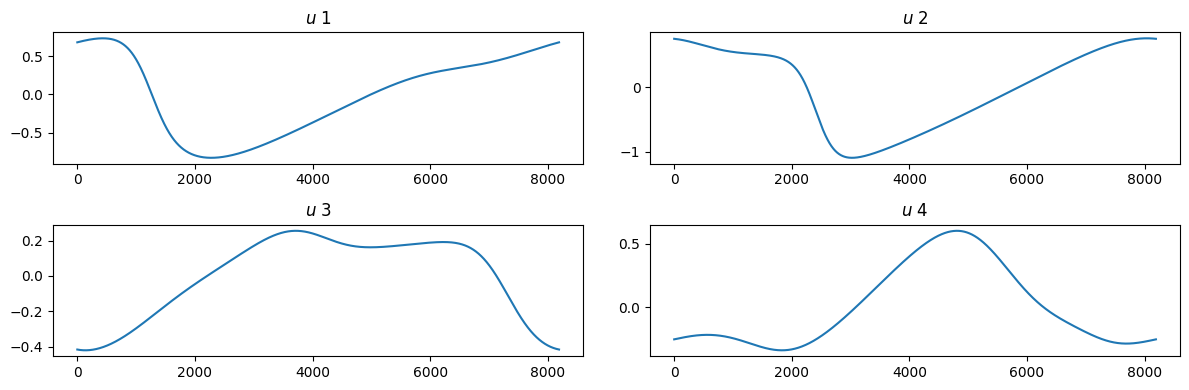

In [8]:
#The final velocity at time t1
u = burgers_data[keys_list[-1]]
plt.figure(figsize = (12,4))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(u[i], label = f"final prediction {i}")
    plt.title(f"$u$ {i+1}")
plt.tight_layout()
plt.show()

##### Data Preparation

In [9]:
#The Trunk Net input: Spatial or positional information
#We will assume the domain has been normalizaed i.e is [0,1]
x_spatial = torch.linspace(0,1,cfg.resolution_original)
t_grid = x_spatial[::cfg.sub_sample].unsqueeze(1)
print(f"The trunk input is of shape {t_grid.shape}")

#Now, we can add the trunk input in our config class
cfg.t_grid = t_grid.to(device)

The trunk input is of shape torch.Size([1024, 1])


In [10]:
def prepare_data(raw_data, cfg):
    #First we extract and downsample our input and output data
    branch_input_data = torch.tensor(raw_data['a'], dtype = torch.float)[:,::cfg.sub_sample]   #shape: (batch, Nx)
    target_data = torch.tensor(raw_data['u'], dtype = torch.float)[:,::cfg.sub_sample]  #shape: (batch, Nx)


    #We need to assert that the shape matches our expectation
    expected_resolution = cfg.resolution_original//cfg.sub_sample
    assert branch_input_data.shape[1] == expected_resolution, f"Expected downsized sample {expected_resolution}, but got {branch_input_data.shape[1]}"
    print(f'For the downsampled dataset --> input: {branch_input_data.shape}, target: {target_data.shape}')
    cfg.branch_input = branch_input_data.shape[1] #Store the branch input dimension, as it will be needed in the NN module

      
    #Next we split the downsampled dataset into training, testing and validation
    dataset = TensorDataset(branch_input_data, target_data)
    test_data_num = int(0.1 * cfg.total_batches)
    branch_train_set, val_set, test_set = random_split(dataset, [cfg.total_batches - 2*test_data_num, test_data_num, test_data_num])
    print(f"Train samples: {len(branch_train_set)}, test samples: {len(test_set)}, validation_samples: {len(test_set)}")


    


    #Creating the dataloader
    train_loader = DataLoader(branch_train_set, batch_size=cfg.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False, num_workers = 3)
    
    return train_loader, test_loader, val_loader

In [11]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        burgers_data = loadmat(cfg.dataset_path)
        self.train_loader, self.test_loader, self.val_loader= prepare_data(burgers_data,self.cfg)
        print('DataLoaded Successfully!!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)
data_module.setup()

For the downsampled dataset --> input: torch.Size([2048, 1024]), target: torch.Size([2048, 1024])
Train samples: 1640, test samples: 204, validation_samples: 204
DataLoaded Successfully!!


#### The DeepONet

In [ ]:
#first we define our NN module for
class NN(nn.Module):
    def __init__(self, cfg, activation, layers , branch = True):
        super().__init__()
        self.activation = activation
        self.tb_dim = cfg.tb_dim
        self.hidden_dim = cfg.hidden_layers
        self.branch_input = cfg.branch_input
        self.layers = layers #The number of layers

        #Defining the linear layers
        self.linears = nn.ModuleList()

        if branch:
            self.linears.append(nn.Linear(self.branch_input, self.hidden_dim)) #The first layer for the branch net
        else:
            self.linears.append(nn.Linear(1, self.hidden_dim)) #The first layer for the trunk net
        #Other layers
        for _ in range(self.layers - 2):
            self.linears.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.linears.append(nn.Linear(self.hidden_dim, self.tb_dim)) #Output is (1024,tb_dim)

    def forward(self,x):
        a = x.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [13]:
class DeepONet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.branch = NN(cfg, activation= nn.Tanh(), layers= 3, branch= True) #Tanh for branch net
        self.trunk = NN(cfg, activation= nn.ReLU(), layers= 2, branch= False) #Relu for trunk net 
        self.cfg = cfg

    def forward(self,x):
        """
        x: shape (batch, 1024)
        t: shape (1024,1)

        output: (batch, 1024)
        """
        t = self.cfg.t_grid

        #The branch net: (batch, 1024) --> (batch, tb_dim)
        B_out = self.branch(x) 

        #The Trunk net: (1024,1) --> (1024,tb_dim)
        T_out = self.trunk(t) 

        #The inner product 
        G = B_out @ T_out.T    #(batch, 1024)

        return G

#### Training

In [ ]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = DeepONet(cfg)
        self.Loss = torch.nn.MSELoss()
        self.metrics = {'train_loss':[], 'val_loss':[]}
        

    def forward(self,x):
        return self.model(x)
        
    def _common_step(self, batch):
        x,y = batch
        y_hat = self(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = self.Loss(y.float(),y_hat.float())
        return loss

    def training_step(self, batch):
        loss = self._common_step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch):
        loss = self._common_step(batch)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch,batch_idx):
        x,y = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]
    

    def evaluate_on_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                predictions.append(y_hat.cpu())
                targets.append(y.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = self.Loss(y,y_hat)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        print(f"Average Loss on test set: {avg_loss:.4f}")
        return avg_loss, predictions, targets        

In [15]:
#Training the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'deeponet_burgers_1d-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    log_every_n_steps = 5,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\checkpoint_burgers_deeponet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | DeepONet | 149 K  | train
1 | Loss  | MSELoss  | 0      | train
-------------------------------------------
149 K     Trainable params
0

For the downsampled dataset --> input: torch.Size([2048, 1024]), target: torch.Size([2048, 1024])
Train samples: 1640, test samples: 204, validation_samples: 204
DataLoaded Successfully!!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


#### Evaluation

In [16]:
#First load best model with validation in checkpoint
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("deeponet_burgers_1d-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(checkpoint_path, cfg=cfg)
avgloss, preds, exact = model.evaluate_on_test_set(data_module.test_dataloader())

Average Loss on test set: 0.0235


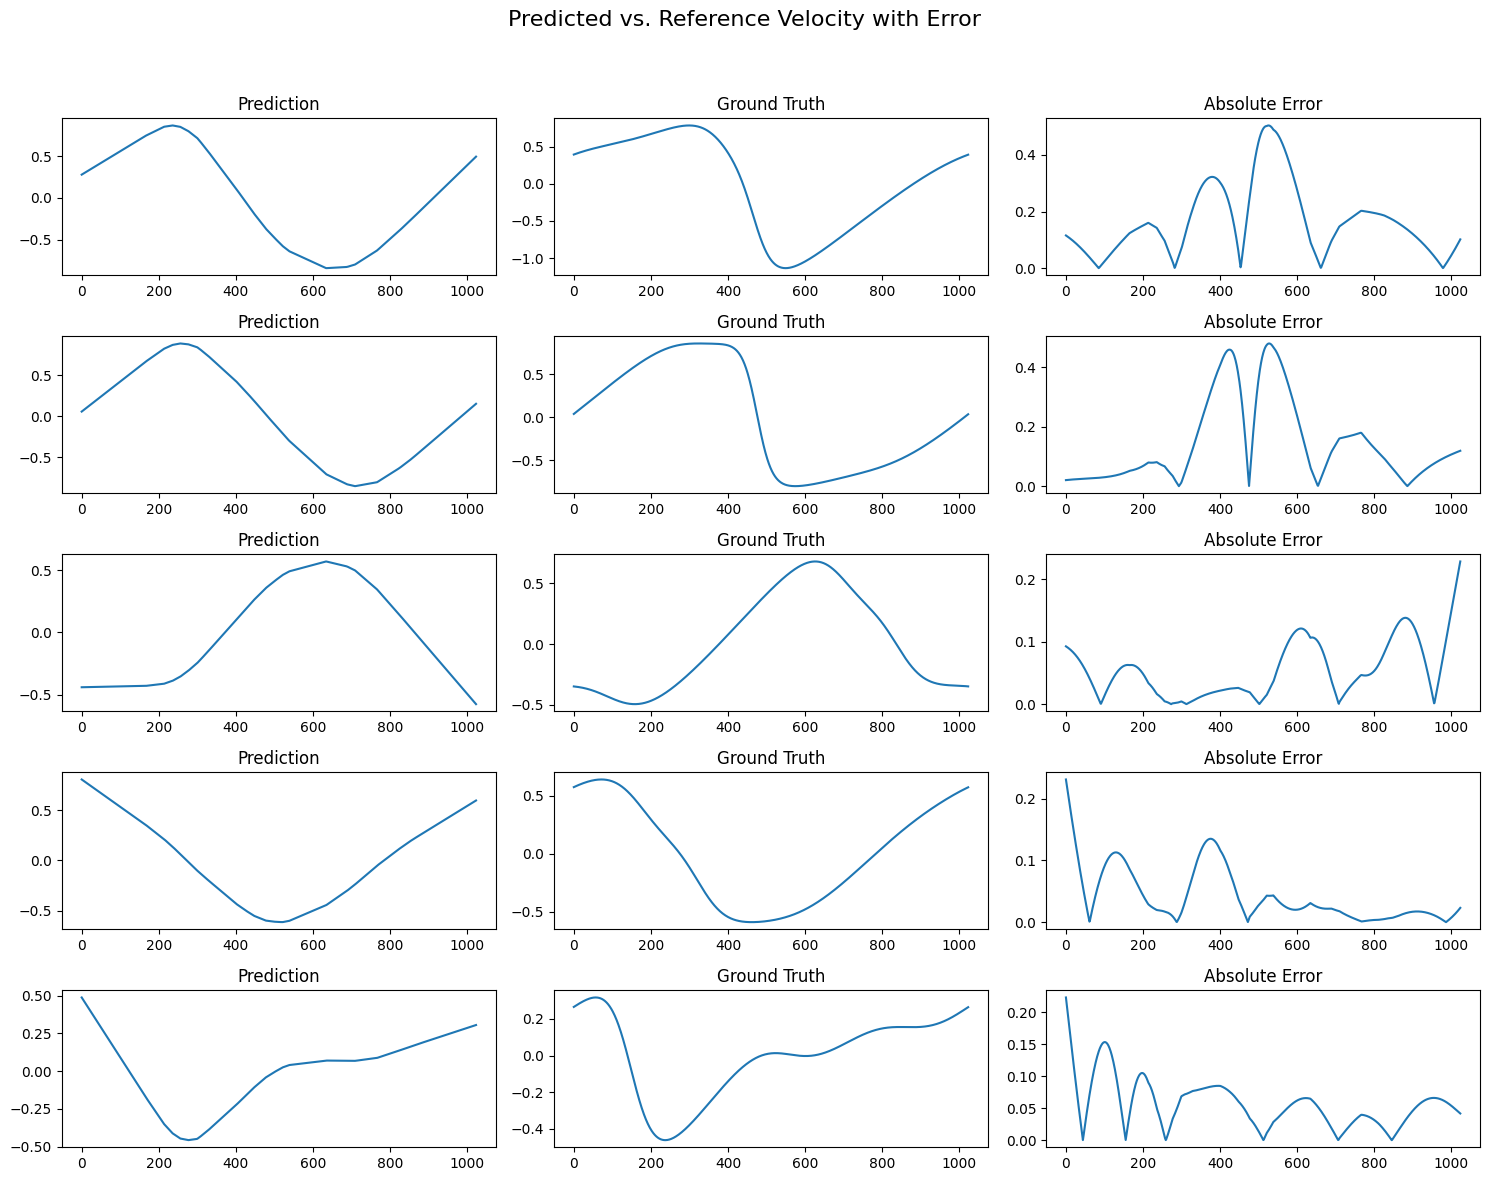

In [20]:
plt.figure(figsize=(15, 12))
plt.suptitle("Predicted vs. Reference Velocity with Error", fontsize=16)

n = 0
for i in range(5):  # Plot 5 samples: pred + target + error
    # Prediction
    plt.subplot(5, 3, 3 * i + 1)
    plt.plot(preds[n][i, :].cpu().numpy())
    plt.title(f"Prediction")

    # Ground truth
    plt.subplot(5, 3, 3 * i + 2)
    plt.plot(exact[n][i, :])
    plt.title(f"Ground Truth")

    # Absolute error
    plt.subplot(5, 3, 3 * i + 3)
    error = np.abs(preds[n][i, :].cpu().numpy() - exact[n][i, :].numpy())
    plt.plot(error)
    plt.title(f"Absolute Error")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Note: We can also make predictions with different spatial resolutions**

#### References

Lu, L., Jin, P., & Karniadakis, G. E. (2019). *DeepONet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operators*. arXiv preprint arXiv:1910.03193. https://arxiv.org/abs/1910.03193
